In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
import torch

if torch.cuda.is_available():
    print(f"✅ CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ CUDA not available. Using CPU.")

✅ CUDA is available. Number of GPUs: 1
GPU Name: NVIDIA T500


In [3]:
# ✅ Replace with your actual CSV file path
csv_file_path = r"C:\Users\cx3garg\Repo\Test\CV_CL\BIOS\surgeon_extracted.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path, encoding="utf-8")

# Convert all string entries in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df


C:\Users\cx3garg\AppData\Local\Temp\ipykernel_18876\734507193.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,hard_text,profession,gender,skills_extracted,education_extracted,countries_extracted,experience_years
0,dr. chung's patients gave him an average ratin...,surgeon,male,[],[],[],NaN
1,he specializes in the use of arthroscopy in th...,surgeon,male,[],[],['toronto'],NaN
2,dr. sherwood graduated from new york medical c...,surgeon,male,[],[],['sidney'],47.0
3,dr. brown graduated from new york medical coll...,surgeon,male,[],[],[],13.0
4,he is a diplomat of the american board of surg...,surgeon,male,[],[],['dallas'],NaN
...,...,...,...,...,...,...,...
195,"she specializes in brachial plexus, complex de...",surgeon,female,[],[],[],NaN
196,ayesha is interested in the re-design of the h...,surgeon,female,[],[],['the united states'],NaN
197,dr. munoz graduated from university of massach...,surgeon,female,[],[],"['new york', 'cigna']",8.0
198,dr mckertich graduated top of her year from th...,surgeon,female,[],[],"['sydney', 'melbourne', 'perth']",NaN


In [4]:

# Use only the 'hard_text' column for text input
texts = df["hard_text"].fillna("").astype(str).tolist()

print("Number of valid texts:", len(texts))
print(texts[:5])  # preview


Number of valid texts: 200
["dr. chung's patients gave him an average rating of 4.0 out of 5 stars. his areas of expertise include the following: dermabrasion, vaginoplasty, and breast augmentation. he is affiliated with lehigh valley hospital (lvh), sacred heart hospital (pensacola, fl), and aesthetic surgery associates. he is an in-network provider for coventry, united healthcare hsa, and united healthcare hmo, as well as other insurance carriers. dr. chung welcomes new patients. after completing medical school at umdnj-new jersey medical school, he performed his residency at lehigh valley hospital network. he has received the distinction of realself top doctor. in addition to english, dr. chung speaks mandarin.", 'he specializes in the use of arthroscopy in the management of a wide spectrum of pathologies. his goal is to help children and teenagers recover from injuries and return to activities by developing individualized surgical and non-surgical care plans. he earned his medical 

In [5]:
# Remove NaN, non-string, or empty values
texts = [t for t in texts if isinstance(t, str) and t.strip()]

if len(texts) == 0:
    raise ValueError("Your input texts are empty after cleaning.")


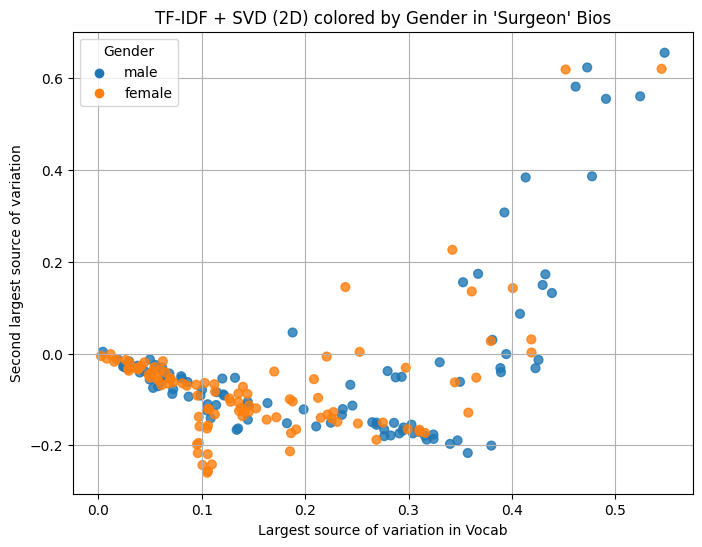

In [15]:

# ✅ Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# ✅ Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# ✅ Clustering visualization (scatter plot)
plt.figure(figsize=(8, 6))

gender_col = "gender"

# Mask for male/female rows (optional but clean)
mask = df[gender_col].isin(["male", "female"])

# Assign colors
color_map = {"male": "C0", "female": "C1"}
colors = df.loc[mask, gender_col].map(color_map)

# Scatter plot
plt.scatter(reduced_matrix[mask, 0], reduced_matrix[mask, 1],  c=colors, s=40, alpha=0.8)

# Add legend manually
for g, c in color_map.items():
    plt.scatter([], [], c=c, label=g)

plt.legend(title="Gender")
plt.title("TF-IDF + SVD (2D) colored by Gender in 'Surgeon' Bios")
plt.xlabel("Largest source of variation in Vocab")
plt.ylabel("Second largest source of variation")
plt.grid(True)
plt.show()

In [7]:
# Text → TF-IDF vectors
X = tfidf_vectorizer.transform(texts)
y = (df["gender"] == "female").astype(int)   # female=1, male=0

In [8]:

# gender vector: female=1, male=0
gender = (df[gender_col] == "female").astype(int).values

# tfidf matrix: X
word_gender_corr = np.corrcoef(X.toarray().T, gender)[-1, :-1]

In [9]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def component_table(comp_idx, topn=20):
    comp = svd.components_[comp_idx]
    top_idx = np.argsort(comp)[-topn:][::-1]

    rows = []
    for i in top_idx:
        rows.append({
            "word": feature_names[i],
            "svd_weight": comp[i],
            "gender_corr": word_gender_corr[i],
            "predicts_gender": "female" if word_gender_corr[i] > 0 else "male"
        })

    return pd.DataFrame(rows)



In [10]:
table1 = component_table(0, 20)
table2 = component_table(1, 20)


print("Component 1 — Top Words and Gender Association")
display(table1)

print("\nComponent 2 — Top Words and Gender Association")
display(table2)



Component 1 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,blue,0.375253,-0.149454,male
1,dr,0.310660,-0.126584,male
2,medical,0.232689,-0.068731,male
3,university,0.211304,-0.039660,male
4,hospital,0.201962,-0.071099,male
5,center,0.188398,-0.113248,male
6,cross,0.180734,-0.155329,male
7,shield,0.180228,-0.145942,male
8,surgery,0.157315,-0.014386,male
9,medicine,0.155639,-0.115062,male



Component 2 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,blue,0.602528,-0.149454,male
1,shield,0.286415,-0.145942,male
2,cross,0.273014,-0.155329,male
3,bronze,0.104920,-0.002656,male
4,carriers,0.104848,-0.062507,male
5,epo,0.083192,-0.042321,male
6,choice,0.073421,-0.042831,male
7,network,0.067578,-0.065733,male
8,average,0.067557,-0.127194,male
9,stars,0.065499,-0.138972,male


In [11]:
# -------------------------
# Gender classifier 

# 2. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 3. Map coefficients to words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# 4. Create DataFrame with word, coefficient, and predicted gender association
# Positive coefficient → more associated with Female (1), negative → Male (0)
word_gender_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients,
    'predicted_gender': ['Female' if c > 0 else 'Male' for c in coefficients]
}).sort_values(by='coefficient', ascending=False)

# 5. Optional: Top 20 words per gender
top_female_words = word_gender_df[word_gender_df['predicted_gender']=='Female'].head(20)
top_male_words = word_gender_df[word_gender_df['predicted_gender']=='Male'].tail(20)

# Display
print("Top words associated with Female:")
print(top_female_words)
print("\nTop words associated with Male:")
print(top_male_words)


Top words associated with Female:
              word  coefficient predicted_gender
637         dental     1.134216           Female
1433            ms     0.665743           Female
399    butterfield     0.405369           Female
1442         munoz     0.386500           Female
322            bds     0.385843           Female
1364        member     0.375490           Female
1440        mumbai     0.374506           Female
677        disease     0.367194           Female
2196        tormey     0.362835           Female
1707      prejeant     0.358242           Female
473           chen     0.351706           Female
2207    transplant     0.349404           Female
2376       working     0.346031           Female
980          hirsh     0.341476           Female
538      completed     0.337671           Female
829         fixing     0.335157           Female
511        college     0.329575           Female
780     extraction     0.328510           Female
2194         tooth     0.328510    

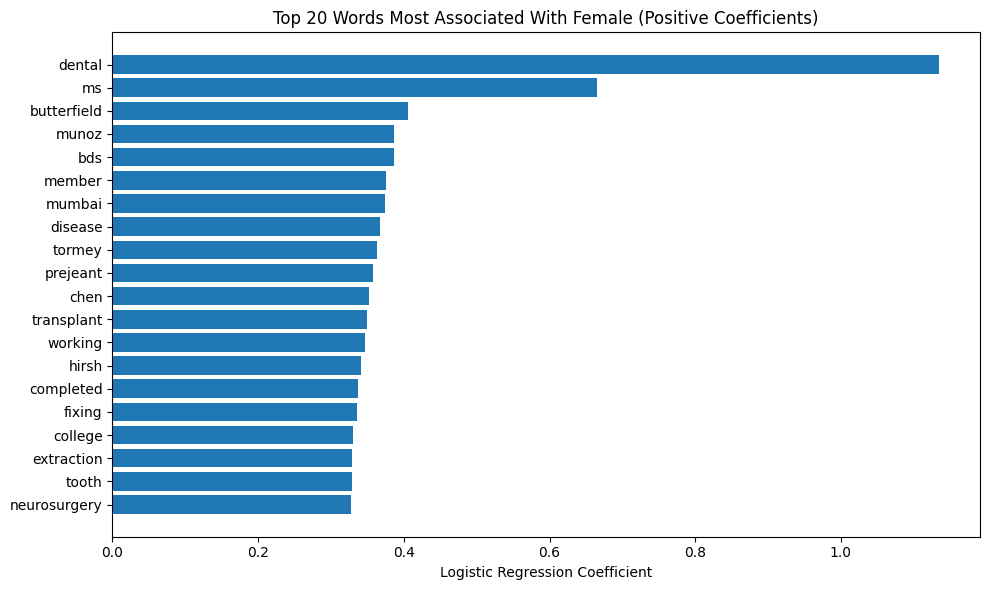

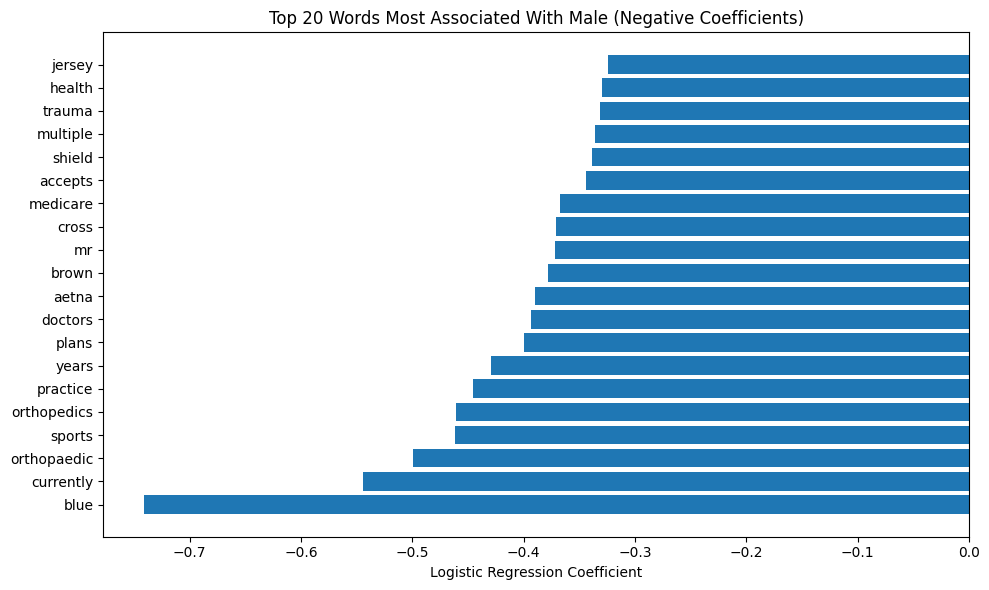

In [12]:
import matplotlib.pyplot as plt

# --- Top 20 words most associated with Female ---
plt.figure(figsize=(10, 6))
plt.barh(top_female_words["word"], top_female_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Female (Positive Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# --- Top 20 words most associated with Male ---
plt.figure(figsize=(10, 6))
plt.barh(top_male_words["word"], top_male_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Male (Negative Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()


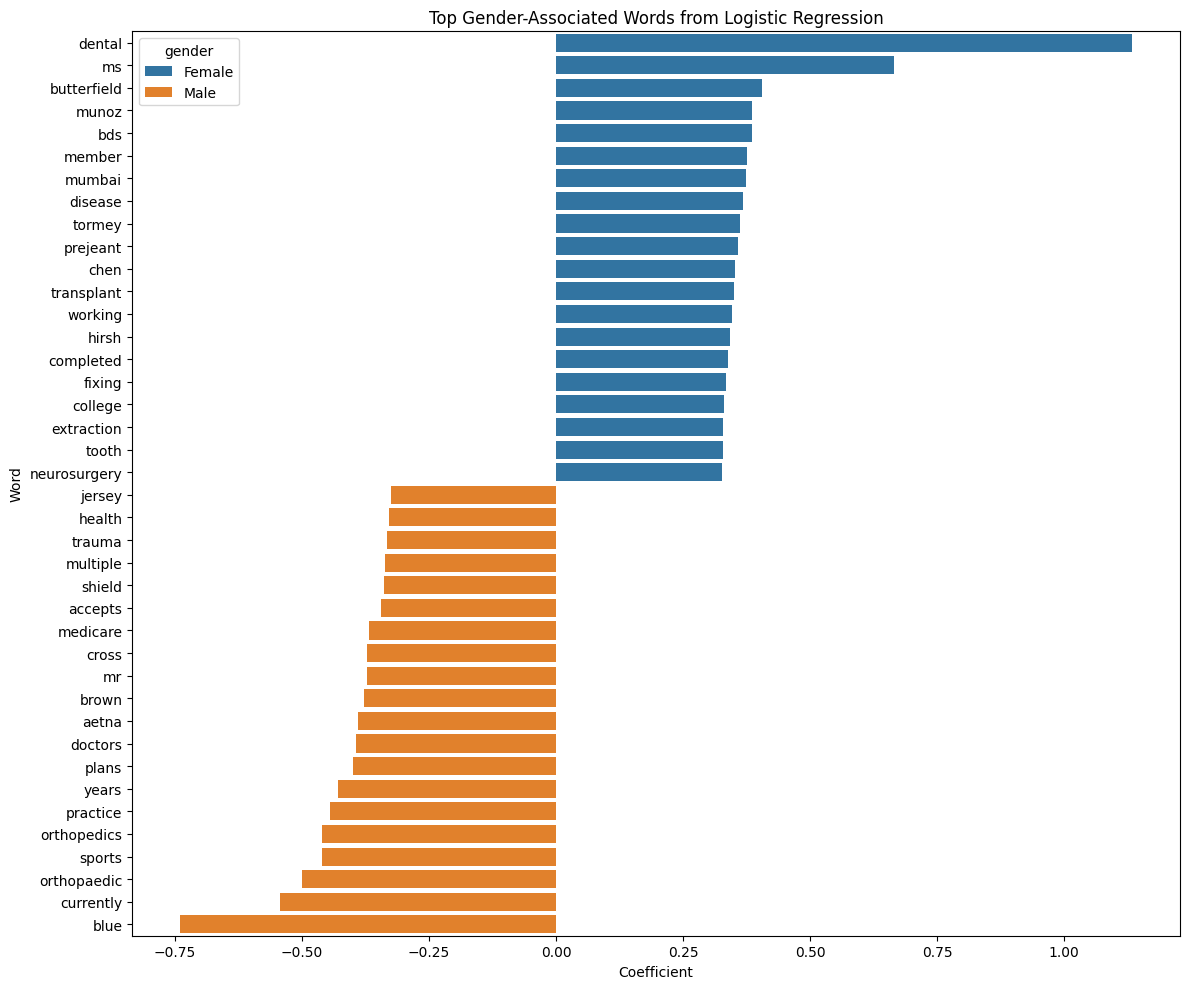

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = pd.concat([
    top_female_words.assign(gender="Female"),
    top_male_words.assign(gender="Male")
])

plt.figure(figsize=(12, 10))
sns.barplot(
    data=subset,
    y="word",
    x="coefficient",
    hue="gender",
    dodge=False
)
plt.title("Top Gender-Associated Words from Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


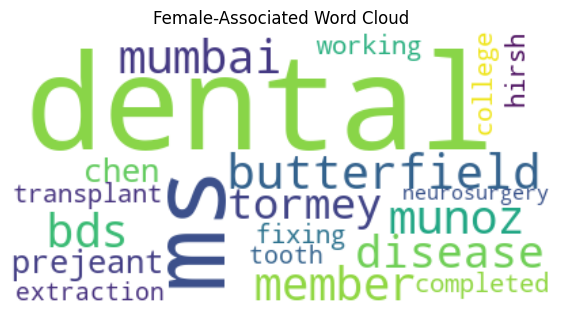

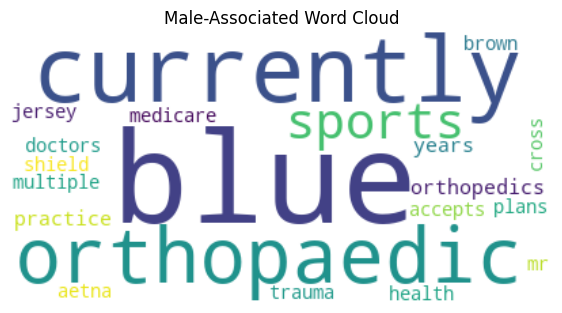

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

female_weights = {row.word: row.coefficient for _, row in top_female_words.iterrows()}
male_weights = {row.word: -row.coefficient for _, row in top_male_words.iterrows()}

# Female
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(female_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Female-Associated Word Cloud")
plt.show()

# Male
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(male_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Male-Associated Word Cloud")
plt.show()
